In [1]:
import os
import sys
import json
import time
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from scipy import signal, fftpack, stats, ndimage
import statsmodels.stats.multitest as multitest

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

In [5]:
plt.rcParams.update({'font.size': 12})

Load CCF for identifying cortical areas

In [6]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [7]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [8]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
#     'VIS-TH': [
#         'LD', 'LGd-sh', 'LGd-co', 'LGd-ip', 'LGv', 'LP', 'MGd', 'MGm', 'MGv'
#     ] # CK said MGd/m/v is auditory?
}

area_colors = {
    'MO': 'blue',
    'ACA': 'deepskyblue',
    'SS': 'blueviolet',
    'VIS': 'green',
    'MO-TH': 'steelblue',
}

In [9]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

#### Functions

In [10]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

In [11]:
def get_responsive_pvalue(spike_times, spike_clusters, unit_ids, events, response_window=[0.002, 0.1], apply_mc_corr=True):
    wstat = np.zeros(len(unit_ids), dtype=float) * np.nan
    pvals = np.zeros(len(unit_ids), dtype=float) * np.nan
    spcounts = np.zeros(len(unit_ids), dtype=float) * np.nan
    
    for indi, uniti in enumerate(unit_ids):
        spikesi = np.squeeze(spike_times[spike_clusters == uniti])

        pre_spcounts = np.zeros(len(events), dtype=int)
        post_spcounts = np.zeros(len(events), dtype=int)
        for j, E in enumerate(events):
            pre_spcounts[j] = np.sum((spikesi >= E-response_window[1]) & (spikesi <= E-response_window[0]))
            post_spcounts[j] = np.sum((spikesi >= E+response_window[0]) & (spikesi <= E+response_window[1]))
        
#         if (post_spcounts - pre_spcounts).any():
            # stats.wilcoxon tests whether the differences x-y is symmetric about zero #
        wstat[indi], pvals[indi] = stats.wilcoxon(x=post_spcounts, y=pre_spcounts, zero_method='zsplit')
            # added zero-method as zsplit because many of the units have too few non-zero samples #
            # this includes the zeros in ranking, but splits them evenly between positive and negative difference ranks #
        spcounts[indi] = np.mean(post_spcounts) - np.mean(pre_spcounts)
        
    if apply_mc_corr:
#         print('Applying multiple comparisons correction...')
        rej, pvals = multitest.fdrcorrection(pvals) #, alpha=0.01) # default alpha=0.05

    return pvals, spcounts

### Define data path

In [12]:
rec_folder = r'F:\EEG_exp\mouse571619\estim2_2021-03-19_10-09-01\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

comp_states = {
    'antMOs_500': {'awake': [0], 'anesthetized': [3]},
    'antMOs_1200': {'awake': [1], 'anesthetized': [2]},
}

Experiment type: electrical stimulation
SomnoSuite log file not found.


In [13]:
# Make a folder in my OneDrive to save plots
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)
figsavedir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs\pop_timing'
if not os.path.exists(figsavedir):
    os.mkdir(figsavedir)
    
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

estim2


#### Load stim table and speed signal

In [14]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,good
0,biphasic,40,0.0004,319.16422,319.16462,0,True
1,biphasic,20,0.0004,322.69724,322.69764,0,True
2,biphasic,40,0.0004,326.75887,326.75927,0,True
3,biphasic,60,0.0004,331.14116,331.14156,0,True
4,biphasic,60,0.0004,335.31077,335.31117,0,True


In [15]:
run_signal, run_timestamps = exp.load_running()

In [16]:
## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(exp.mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(exp.experiment_folder))))
)].squeeze()
        
## Get PCI_stim_amp from metadata ##
currentstr = exp_meta['Current (uA)'].replace(' ','')
currents_list = []
for char in currentstr.split('/'):
    if char.isdecimal():
        currents_list.append(char)
if len(currents_list) > 1:
    PCI_stim_amp = currents_list[1]
elif len(currents_list) == 1:
    PCI_stim_amp = currents_list[0]
else:
    print('No stim current listed in Zap_Zip-log_exp')
print(currents_list)
print(PCI_stim_amp)

['20', '40', '60']
40


#### Load unit data

In [17]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeC', 'probeF']


In [18]:
probe_unit_data = {}
total_units = 0
for probei in probe_list:
    print(probei)
    probe_unit_data[probei] = {}
    
    ## Load probe_info.json ##
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip (ch 0 is 20 um from tip)
    ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"
    print(' surface channel: {:d}'.format(surface_ch))
    
    ## Get all ch depths ##
    npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
    probe_unit_data[probei]['ch_depths'] = allch_z[surface_ch] - allch_z
    
    ## Select units and get peak chs ##
    select_units, peak_chs, unit_metrics = exp.get_probe_units(probei)
    unit_metrics['cell_type'] = unit_metrics['duration'].apply(lambda x: 'FS' if x <= 0.4 else 'RS')
    print(' unit count: {:d}'.format(len(select_units)))
    
    ## Sort units ##
    all_units = select_units[np.squeeze(np.argsort(peak_chs))]
    all_units_chs = peak_chs[np.squeeze(np.argsort(peak_chs))]
    all_units_types = unit_metrics['cell_type'].values[np.squeeze(np.argsort(peak_chs))]
    probe_unit_data[probei]['units'] = all_units
    probe_unit_data[probei]['chs'] = all_units_chs
    probe_unit_data[probei]['cell_type'] = all_units_types
    if 'area' in unit_metrics.columns:
        all_units_areas = unit_metrics.area.values[np.squeeze(np.argsort(peak_chs))]
        probe_unit_data[probei]['areas_assigned'] = True
        probe_unit_data[probei]['areas'] = all_units_areas
    else:
        print(' unit metrics file does not have area assignments.')
        probe_unit_data[probei]['areas_assigned'] = False
    total_units += len(probe_unit_data[probei]['units'])
            
    ## Load spike times and cluster ids ##
    probe_unit_data[probei]['spike_times'] = np.load(exp.ephys_params[probei]['spike_times'])
    probe_unit_data[probei]['spike_clusters'] = np.load(exp.ephys_params[probei]['spike_clusters'])
print('Total unit count: {:d}'.format(total_units))

probeB
 surface channel: 340
 unit count: 218
probeC
 surface channel: 350
 unit count: 343
probeF
 surface channel: 285
 unit count: 298
Total unit count: 859


## Get trial times

In [20]:
rest_trials_only = True
all_event_times = {}
for expdes, state_sweeps in comp_states.items():
    print(expdes)
    all_event_times[expdes] = {}
    for parami in currents_list:
        print('biphasic - {} \u03bcA'.format(parami))
        all_event_times[expdes][parami] = {}
        for statei, sweeps in state_sweeps.items():
            ## Get all event times for statei ##
            state_events = []
            for sweepi in sweeps:
                events = get_stim_events(stim_log, 'biphasic', parami, sweepi)
                if len(events) == 0:
                    continue
                state_events.append(events)
            state_events = np.concatenate(state_events)

            ## Get mean speed for all events ##
            rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
            event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
            mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
            rest_events = np.nonzero(mean_speed == 0)[0]
            print(' {} state: resting trials {:d}/{:d}'.format(statei, len(rest_events), len(state_events)))

            if rest_trials_only:
                all_event_times[expdes][parami][statei] = state_events[rest_events]
            else:
                all_event_times[expdes][parami][statei] = state_events
    print('')

antMOs_500
biphasic - 20 μA
 awake state: resting trials 90/112
 anesthetized state: resting trials 120/120
biphasic - 40 μA
 awake state: resting trials 89/110
 anesthetized state: resting trials 119/119
biphasic - 60 μA
 awake state: resting trials 94/115
 anesthetized state: resting trials 120/120

antMOs_1200
biphasic - 20 μA
 awake state: resting trials 104/119
 anesthetized state: resting trials 120/120
biphasic - 40 μA
 awake state: resting trials 97/118
 anesthetized state: resting trials 120/120
biphasic - 60 μA
 awake state: resting trials 103/120
 anesthetized state: resting trials 120/120



### Categorize responsive units

In [21]:
raster_window = [-1.0, 1.0]
spcount_window = [0.002, 0.025] # [0.002, 0.025] [0.025, 0.125]
alpha = 0.05

In [22]:
unit_trial_spikes = {}
unit_responses = {}
for expdes in all_event_times.keys():
    unit_trial_spikes[expdes] = {}
    unit_responses[expdes] = {}
    for parami, statesevents in all_event_times[expdes].items():
        unit_trial_spikes[expdes][parami] = {}
        unit_responses[expdes][parami] = {}
        for statei, events in statesevents.items():
            unit_trial_spikes[expdes][parami][statei] = {}
            ## Loop through probes to get unit responsiveness ##
            units_list = []
            areas_list = []
            parents_list = []
            depths_list = []
            types_list = []
            response_list = []
            for probei, unit_data in probe_unit_data.items():
                ## Get trial spikes for each unit ##
                for unitind, uniti in enumerate(unit_data['units']):
                    spikesi = np.squeeze(unit_data['spike_times'][unit_data['spike_clusters'] == uniti])
                    event_raster = []
                    for eventi in events:
                        spikeinds = np.squeeze(
                            np.argwhere((spikesi > eventi + raster_window[0]) & (spikesi < eventi + raster_window[1]))
                        )
                        event_raster.append(spikesi[spikeinds] - eventi)
                    unit_trial_spikes[expdes][parami][statei][probei[-1] + str(uniti)] = event_raster
                ## Get responsiveness ##
                unit_ids = [probei[-1] + str(x) for x in unit_data['units']]
                unit_pvals, unit_spcounts = get_responsive_pvalue(
                    unit_data['spike_times'],
                    unit_data['spike_clusters'],
                    unit_data['units'],
                    events,
                    spcount_window,
                )

                ## Loop through all units and add to the correct population ##
                probe_parent_list = []
                probe_response_list = []
#                 probe_unit_depths = []
                for unitind in range(unit_pvals.shape[0]):
                    parent_region = [
                        key for key in list(areas_of_interest.keys()) if unit_data['areas'][unitind] in areas_of_interest[key]
                    ]
#                     probe_unit_depths.append(unit_data['ch_depths'][unit_data['chs'][unitind]])
                    if unit_pvals[unitind] < alpha and unit_spcounts[unitind] > 0:
                        probe_response_list.append('excited')
                    elif unit_pvals[unitind] < alpha and unit_spcounts[unitind] < 0:
                        probe_response_list.append('inhibited')
                    else:
                        probe_response_list.append('ns')
                    if len(parent_region) == 1:
                        probe_parent_list.append(parent_region[0])
                    else:
                        probe_parent_list.append('none')

                units_list.append(unit_ids)
                areas_list.append(unit_data['areas'])
                parents_list.append(probe_parent_list)
                depths_list.append(unit_data['ch_depths'][unit_data['chs']])
                types_list.append(unit_data['cell_type'])
                response_list.append(probe_response_list)

            ## Make a dataframe with all of the unit data
            unit_responses[expdes][parami][statei] = pd.DataFrame({
                    'unit_id': np.concatenate(units_list),
                    'area': np.concatenate(areas_list),
                    'parent': np.concatenate(parents_list),
                    'unit_depths': np.concatenate(depths_list),
                    'cell_type': np.concatenate(types_list),
                    'response': np.concatenate(response_list),
                })

### Examine different aspects of timing in populations and responsive cells.

In [36]:
ROI = ['MO', 'ACA', 'SS', 'VIS']
plot_cell_type = 'RS'
plot_response_type = 'excited'
plexp = 'antMOs_1200'
plstim = '60'
plstate = 'awake' # 'anesthetized' 'awake'

Compare latency to first spike in responsive units for a single subject and trial type. Could also include:
- probability of eliciting a first spike
- baseline firing rate of each cell

In [37]:
df = unit_responses[plexp][plstim][plstate]
pop_median_first_spikes = {}
for region in ROI:
    UOI = df[(
        (df['parent'] == region) &
        (df['cell_type'] == plot_cell_type) &
        (df['response'] == plot_response_type)
    )].unit_id.values
    all_units_first_spikes = []
    for uniti in UOI:
        first_spikes = []
        for indi, spikes in enumerate(unit_trial_spikes[plexp][plstim][plstate][uniti]):
            if not isinstance(spikes, np.ndarray):
                spikes = np.array([spikes])
            early_spikes = np.nonzero((spikes > 0) & (spikes < spcount_window[1]))[0]
            if len(early_spikes) > 0:
                first_spikes.append(spikes[early_spikes[0]])
        all_units_first_spikes.append(np.median(first_spikes))
    pop_median_first_spikes[region] = np.array(all_units_first_spikes)

## Mann-Whitney U test ##
U, pval = stats.mannwhitneyu(pop_median_first_spikes['MO'], pop_median_first_spikes['MO-TH'], alternative='less')

## Plot it ##
fig, ax = plt.subplots()
x = np.arange(len(pop_median_first_spikes))
for ii, (region, medfspikes) in enumerate(pop_median_first_spikes.items()):
    ax.boxplot(medfspikes, positions=[x[ii]], showfliers=False)
    xs = np.random.normal(ii, 0.04, len(medfspikes))
    ax.scatter(xs, medfspikes, c=area_colors[region], alpha=0.25)
ax.set_xticklabels(pop_median_first_spikes.keys())
ax.set_ylabel('Latency to first spike (s)')
# annotate with asterisk
if pval < 0.01:
    ax.annotate(
        'p={:.2E}\n*'.format(pval), xy=(0.5, 0.75), xycoords='axes fraction', fontsize=11, fontweight='bold', ha='center')
ax.set_title('Latency to first spike (median)\n{}: {} {} \u03bcA\n{} {} units'.format(
    plexp, plstate, plstim, plot_response_type, plot_cell_type
))

## Save ##
figname = 'Latency_1stspike_{}_{}{}_{}{}.png'.format(exp.mouse, plstate, plstim, plot_response_type, plot_cell_type)
# fig.savefig(os.path.join(figsavedir, figname), transparent=True)

KeyError: 'MO-TH'

Repeat for all cells in population, not just excited RS.

<IPython.core.display.Javascript object>


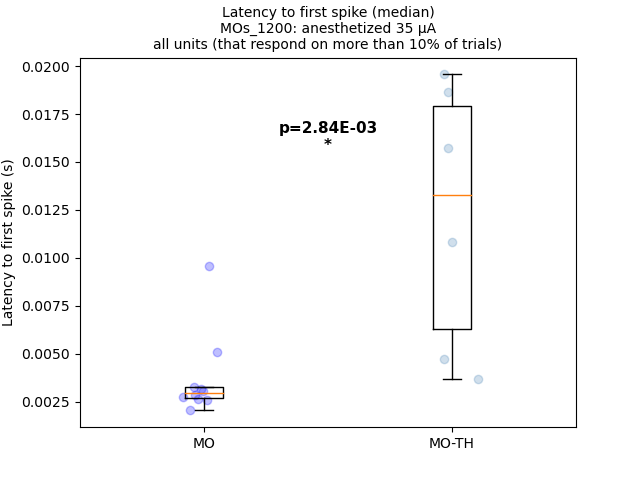

In [120]:
trialnumthresh = len(all_event_times[plexp][plstim][plstate]) * 0.1

df = unit_responses[plexp][plstim][plstate]
pop_median_first_spikes = {}
for region in ROI:
    UOI = df[df['parent'] == region].unit_id.values
    all_units_first_spikes = []
    for uniti in UOI:
        first_spikes = []
        for indi, spikes in enumerate(unit_trial_spikes[plexp][plstim][plstate][uniti]):
            if not isinstance(spikes, np.ndarray):
                spikes = np.array([spikes])
            early_spikes = np.nonzero((spikes > 0) & (spikes < spcount_window[1]))[0]
            if len(early_spikes) > 0:
                first_spikes.append(spikes[early_spikes[0]])
        if len(first_spikes) > trialnumthresh:
            all_units_first_spikes.append(np.median(first_spikes))
    pop_median_first_spikes[region] = np.array(all_units_first_spikes)

## Mann-Whitney U test ##
U, pval = stats.mannwhitneyu(pop_median_first_spikes['MO'], pop_median_first_spikes['MO-TH'], alternative='less')

## Plot it ##
fig, ax = plt.subplots()
x = np.arange(len(pop_median_first_spikes))
for ii, (region, medfspikes) in enumerate(pop_median_first_spikes.items()):
    ax.boxplot(medfspikes, positions=[x[ii]], showfliers=False)
    xs = np.random.normal(ii, 0.04, len(medfspikes))
    ax.scatter(xs, medfspikes, c=area_colors[region], alpha=0.25)
ax.set_xticklabels(pop_median_first_spikes.keys())
ax.set_ylabel('Latency to first spike (s)')
# annotate with asterisk
if pval < 0.01:
    ax.annotate(
        'p={:.2E}\n*'.format(pval), xy=(0.5, 0.75), xycoords='axes fraction', fontsize=11, fontweight='bold', ha='center')
ax.set_title('Latency to first spike (median)\n{}: {} {} \u03bcA\nall units (that respond on more than 10% of trials)'.format(
    plexp, plstate, plstim
))

## Save ##
figname = 'Latency_1stspike_{}_{}{}_allunits.png'.format(exp.mouse, plstate, plstim)
# fig.savefig(os.path.join(figsavedir, figname), transparent=True)

First spike analysis

<IPython.core.display.Javascript object>


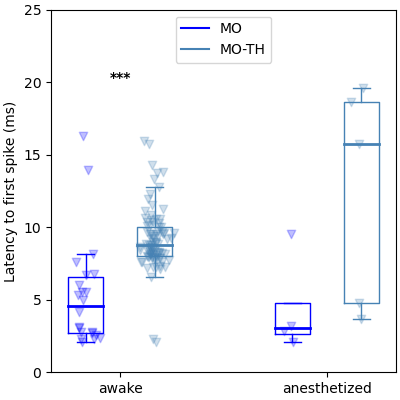

In [38]:
trialnumthresh = len(all_event_times[plexp][plstim][statei]) * 0.1
dualstates = ['awake', 'anesthetized']
catx = np.arange(0, len(dualstates)*2, len(dualstates)+1)

fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
for si, statei in enumerate(dualstates):
    df = unit_responses[plexp][plstim][statei]
    pop_median_first_spikes = {}
    for region in ROI:
        UOI = df[(df['parent'] == region) & (df['cell_type'] == plot_cell_type)].unit_id.values
        all_units_first_spikes = []
        for uniti in UOI:
            first_spikes = []
            for indi, spikes in enumerate(unit_trial_spikes[plexp][plstim][statei][uniti]):
                if not isinstance(spikes, np.ndarray):
                    spikes = np.array([spikes])
                early_spikes = np.nonzero((spikes > 0) & (spikes < spcount_window[1]))[0]
                if len(early_spikes) > 0:
                    first_spikes.append(spikes[early_spikes[0]])
            if len(first_spikes) > trialnumthresh:
                all_units_first_spikes.append(np.median(first_spikes))
        pop_median_first_spikes[region] = np.array(all_units_first_spikes)

    ## Mann-Whitney U test ##
    U, pval = stats.mannwhitneyu(pop_median_first_spikes['MO'], pop_median_first_spikes['MO-TH'], alternative='less')

    ## Plot it ##
    x = catx[si] + np.arange(len(pop_median_first_spikes))
    for ii, (region, medfspikes) in enumerate(pop_median_first_spikes.items()):
        bpl = ax.boxplot(
            medfspikes*1E3, positions=[x[ii]], showfliers=False, widths=0.5,
            boxprops={'color': area_colors[region]},
            capprops={'color': area_colors[region]},
            whiskerprops={'color': area_colors[region]},
            medianprops={'color': area_colors[region], 'linewidth': 2},
        )
        xs = np.random.normal(ii, 0.1, len(medfspikes)) + catx[si]
        ax.scatter(xs, medfspikes*1E3, c=area_colors[region], marker='v', alpha=0.25)
    # annotate with asterisk
    if pval < 0.01:
#         ax.annotate(
#             'p={:.1E}\n*'.format(pval), xy=(np.mean(x), 20), xycoords='data', fontsize=10, fontweight='bold', ha='center')
        ax.annotate(
            '***'.format(pval), xy=(np.mean(x), 20), xycoords='data', fontsize=10, fontweight='bold', ha='center')
#     ax.set_title(
#         'Latency to first spike (median)\n{}: {} \u03bcA\nall units (that respond on more than 10% of trials)'.format(
#         plexp, plstim
#     ))
ax.set_xticks(catx + 0.5)
ax.set_xticklabels(dualstates)
ax.set_ylim([0, spcount_window[1]*1E3])
ax.set_ylabel('Latency to first spike (ms)')

## Make legend ##
for region in ROI:
    ax.plot([], c=area_colors[region], label=region)
ax.legend(loc='upper center')

## Save ##
figname = 'Latency_1stspike_compstates_{}_{}_allunits.png'.format(exp.mouse, plstim)
# fig.savefig(os.path.join(figsavedir, figname), transparent=True)

Second window spike latency analysis

<IPython.core.display.Javascript object>


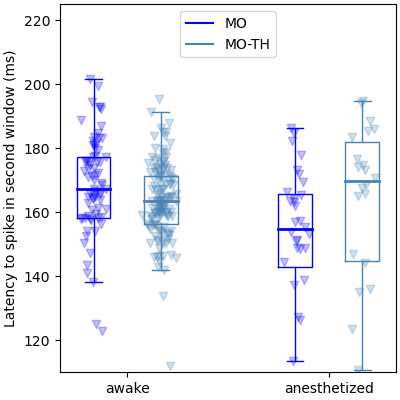

In [51]:
trialnumthresh = len(all_event_times[plexp][plstim][statei]) * 0.1
dualstates = ['awake', 'anesthetized']
catx = np.arange(0, len(dualstates)*2, len(dualstates)+1)
window = [0.025, 0.225]

fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
for si, statei in enumerate(dualstates):
    df = unit_responses[plexp][plstim][statei]
    pop_median_first_spikes = {}
    for region in ROI:
        UOI = df[(df['parent'] == region) & (df['cell_type'] == plot_cell_type)].unit_id.values
        all_units_first_spikes = []
        for uniti in UOI:
            first_spikes = []
            for indi, spikes in enumerate(unit_trial_spikes[plexp][plstim][statei][uniti]):
                if not isinstance(spikes, np.ndarray):
                    spikes = np.array([spikes])
                early_spikes = np.nonzero((spikes > window[0]) & (spikes < window[1]))[0]
                if len(early_spikes) > 0:
                    first_spikes.append(spikes[early_spikes[0]])
            if len(first_spikes) > trialnumthresh:
                all_units_first_spikes.append(np.median(first_spikes))
        pop_median_first_spikes[region] = np.array(all_units_first_spikes)

    ## Mann-Whitney U test ##
    U, pval = stats.mannwhitneyu(pop_median_first_spikes['MO'], pop_median_first_spikes['MO-TH'], alternative='less')

    ## Plot it ##
    x = catx[si] + np.arange(len(pop_median_first_spikes))
    for ii, (region, medfspikes) in enumerate(pop_median_first_spikes.items()):
        bpl = ax.boxplot(
            medfspikes*1E3, positions=[x[ii]], showfliers=False, widths=0.5,
            boxprops={'color': area_colors[region]},
            capprops={'color': area_colors[region]},
            whiskerprops={'color': area_colors[region]},
            medianprops={'color': area_colors[region], 'linewidth': 2},
        )
        xs = np.random.normal(ii, 0.1, len(medfspikes)) + catx[si]
        ax.scatter(xs, medfspikes*1E3, c=area_colors[region], marker='v', alpha=0.25)
    # annotate with asterisk
    if pval < 0.01:
        ax.annotate(
            'p={:.1E}\n*'.format(pval), xy=(np.mean(x), 20), xycoords='data', fontsize=10, fontweight='bold', ha='center')
#         ax.annotate(
#             '***'.format(pval), xy=(np.mean(x), 20), xycoords='data', fontsize=10, fontweight='bold', ha='center')
#     ax.set_title(
#         'Latency to first spike (median)\n{}: {} \u03bcA\nall units (that respond on more than 10% of trials)'.format(
#         plexp, plstim
#     ))
ax.set_xticks(catx + 0.5)
ax.set_xticklabels(dualstates)
ax.set_ylim([110, window[1]*1E3])
ax.set_ylabel('Latency to spike in second window (ms)')

## Make legend ##
for region in ROI:
    ax.plot([], c=area_colors[region], label=region)
ax.legend(loc='upper center')

## Save ##
figname = 'Latency_1stspike_2ndwindow_compstates_{}_{}_RSunits_shorty.png'.format(exp.mouse, plstim)
# fig.savefig(os.path.join(figsavedir, figname), transparent=True)

Make single-unit raster plots and histograms to investigate first spike timing trial-by-trial.

This looks at each region's median first spike on a trial by trial basis, looking for a correlation between the first spike times in the two areas. Not a strong correlation value, but a strong p-value.

In [106]:
df = unit_responses[plexp][plstim][plstate]
region_UOI = {}
for region in ROI:
    region_UOI[region] = df[(
        (df['parent'] == region) &
        (df['cell_type'] == plot_cell_type) &
        (df['response'] == plot_response_type)
    )].unit_id.values
    
region_first_spikes = {key: np.zeros((len(all_event_times[plexp][plstim][plstate])))*np.nan for key in ROI}
for triali in range(len(all_event_times[plexp][plstim][plstate])):
    for region in ROI:
        units_first_spikes = []
        for uniti in region_UOI[region]:
            spikes = unit_trial_spikes[plexp][plstim][plstate][uniti][triali]
            if not isinstance(spikes, np.ndarray):
                spikes = np.array([spikes])
            early_spikes = np.nonzero((spikes > 0) & (spikes < spcount_window[1]))[0]
            if len(early_spikes) > 0:
                units_first_spikes.append(spikes[early_spikes[0]])
        if len(units_first_spikes) > 0:
            region_first_spikes[region][triali] = np.median(units_first_spikes)

<IPython.core.display.Javascript object>


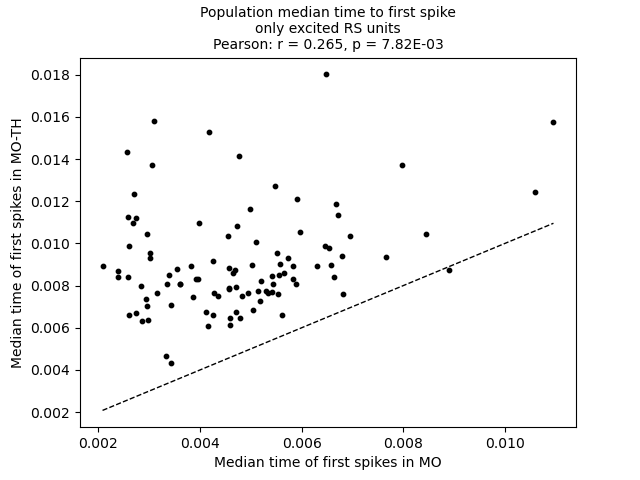

In [107]:
## Linear regression for median time of first spikes ##
mask = ~np.isnan(region_first_spikes['MO']) & ~np.isnan(region_first_spikes['MO-TH'])
# res = stats.linregress(region_first_spikes['MO'][mask], region_first_spikes['MO-TH'][mask])
pearson_r, pearson_p = stats.pearsonr(region_first_spikes['MO'][mask], region_first_spikes['MO-TH'][mask])
minx = np.min(region_first_spikes['MO'][mask])
maxx = np.max(region_first_spikes['MO'][mask])

fig, ax = plt.subplots()
ax.scatter(region_first_spikes['MO'], region_first_spikes['MO-TH'], c='k', s=10)
ax.set_xlabel('Median time of first spikes in MO')
ax.set_ylabel('Median time of first spikes in MO-TH')
ax.plot([minx, maxx], [minx, maxx], linestyle='dashed', color='k', linewidth=1)
# ax.plot(region_first_spikes['MO'], res.intercept + res.slope*region_first_spikes['MO'], 'm', linewidth=0.5)
ax.set_title(
    'Population median time to first spike\nonly {} {} units\nPearson: r = {:.3f}, p = {:.2E}'.format(
        plot_response_type, plot_cell_type, pearson_r, pearson_p))

## Save ##
figname = 'POP{}{}_med1stspike_scatter_{}_{}{}.png'.format(plot_response_type, plot_cell_type, exp.mouse, plstate, plstim)
# fig.savefig(os.path.join(figsavedir, figname), transparent=True)

Plot population rasters for single trials. To do: a subplot for only responsive units?

In [25]:
peak_windows = {'early': [0.0, 0.025], 'late': [0.025, 0.225]}
time_bin = 0.001 # size of time bins (s)
gausswin = 0.005 # duration of convolution (s)

df = unit_responses[plexp][plstim][plstate]
bins = np.arange(raster_window[0], raster_window[1] + time_bin, time_bin)

In [137]:
pop_peak_latency = {
    keyw: {keyr: np.zeros(len(all_event_times[plexp][plstim][plstate]), dtype=float) for keyr in ROI} for keyw in peak_windows
}
for coli, region in enumerate(ROI):
    select_units = df[df['parent'] == region].unit_id.values
    
    for triali in range(len(all_event_times[plexp][plstim][plstate])):
        pop_hist = []
        for indi, uniti in enumerate(select_units):
            pop_counts, edges = np.histogram(unit_trial_spikes[plexp][plstim][plstate][uniti][triali], bins)
            pop_hist.append(pop_counts)
        pop_bin_counts = np.sum(np.array(pop_hist), axis=0)
        popSDF = ndimage.gaussian_filter(pop_bin_counts, sigma=int(gausswin / time_bin), output=float)
        for tt, win in peak_windows.items():
            wininds = np.nonzero((bins >= win[0]) & (bins <= win[1]))[0]
            pop_peak_latency[tt][region][triali] = bins[wininds][np.argmax(popSDF[wininds])]

Plot scatter plot of pop SDF peak latencies for all trials.

<IPython.core.display.Javascript object>


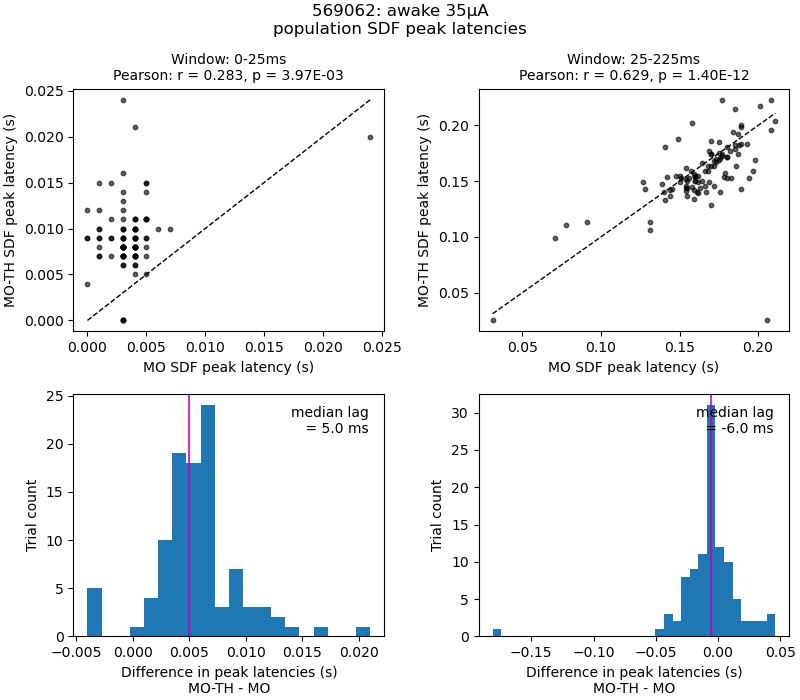

In [175]:
fig, axs = plt.subplots(2, len(pop_peak_latency), figsize=(8,7), constrained_layout=True)

for ii, (tt, win) in enumerate(peak_windows.items()):
    latencies = []
    labels = []
    for region, vals in pop_peak_latency[tt].items():
        latencies.append(vals)
        labels.append(region)
    pearson_r, pearson_p = stats.pearsonr(latencies[0], latencies[1])
    axs[0,ii].scatter(latencies[0], latencies[1], c='k', s=10, alpha=0.6)
    minx = np.min(latencies[0])
    maxx = np.max(latencies[0])
    axs[0,ii].plot([minx, maxx], [minx, maxx], 'k', linewidth=1, linestyle='dashed')
    axs[0,ii].set_xlabel('{} SDF peak latency (s)'.format(labels[0]))
    axs[0,ii].set_ylabel('{} SDF peak latency (s)'.format(labels[1]))
    axs[0,ii].set_title('Window: {:d}-{:d}ms\nPearson: r = {:.3f}, p = {:.2E}'.format(
        int(win[0]*1E3), int(win[1]*1E3), pearson_r, pearson_p))
    
    peak_lags = latencies[1] - latencies[0]
    axs[1,ii].hist(peak_lags)
    axs[1,ii].axvline(np.median(peak_lags), color='m', alpha=0.8)
    axs[1,ii].text(
            0.95, 0.95, 'median lag\n = {:.1f} ms'.format(np.median(peak_lags)*1E3),
            ha='right', va='top', transform=axs[1,ii].transAxes, fontsize=10
        )
    axs[1,ii].set_xlabel('Difference in peak latencies (s)\n{} - {}'.format(labels[1], labels[0]))
    axs[1,ii].set_ylabel('Trial count')
plt.suptitle('{}: {} {}\u03bcA\npopulation SDF peak latencies'.format(exp.mouse, plstate, plstim), fontsize=12)
## Save ##
figname = 'allPOP_peakSDF_scatter_{}_{}{}.png'.format(exp.mouse, plstate, plstim)
# fig.savefig(os.path.join(figsavedir, figname), transparent=True)

Plot trial 2nd peak latencies for populations

9.495278686965936e-28


<IPython.core.display.Javascript object>


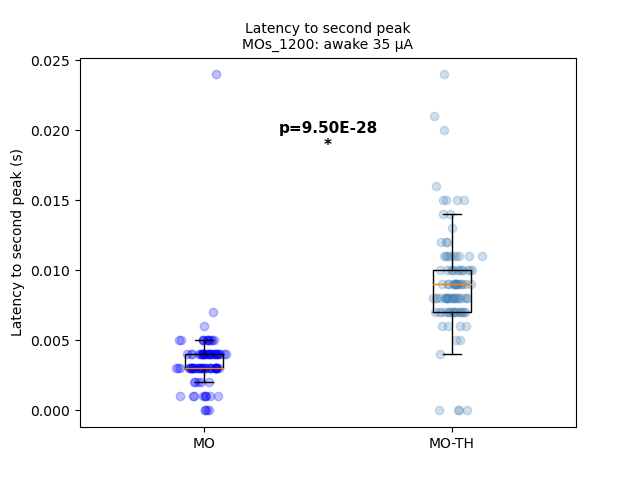

In [139]:
pwin = 'late'
# pop_peak_latency[pwin]
## Mann-Whitney U test ##
# U, pval = stats.mannwhitneyu(pop_peak_latency[pwin]['MO'], pop_peak_latency[pwin]['MO-TH'], alternative='greater')

## Paired t-test ##
pairedt, p2 = stats.ttest_rel(pop_peak_latency[pwin]['MO'], pop_peak_latency[pwin]['MO-TH'], nan_policy='omit')
pval = p2 / 2
print(pval)

## Plot it ##
fig, ax = plt.subplots()
x = np.arange(len(pop_median_first_spikes))
for ii, (region, peaklats) in enumerate(pop_peak_latency[pwin].items()):
    ax.boxplot(peaklats, positions=[x[ii]], showfliers=False)
    xs = np.random.normal(ii, 0.04, len(peaklats))
    ax.scatter(xs, peaklats, c=area_colors[region], alpha=0.25)
ax.set_xticklabels(pop_peak_latency[pwin].keys())
ax.set_ylabel('Latency to second peak (s)')
# annotate with asterisk
if pval < 0.01:
    ax.annotate(
        'p={:.2E}\n*'.format(pval), xy=(0.5, 0.75), xycoords='axes fraction', fontsize=11, fontweight='bold', ha='center')
ax.set_title('Latency to second peak\n{}: {} {} \u03bcA'.format(plexp, plstate, plstim))

## Save ##
figname = 'Latency_2ndpeak_{}_{}{}_allunits_trials.png'.format(exp.mouse, plstate, plstim, plot_response_type, plot_cell_type)
# fig.savefig(os.path.join(figsavedir, figname), transparent=True)

Plot example single trials

<IPython.core.display.Javascript object>


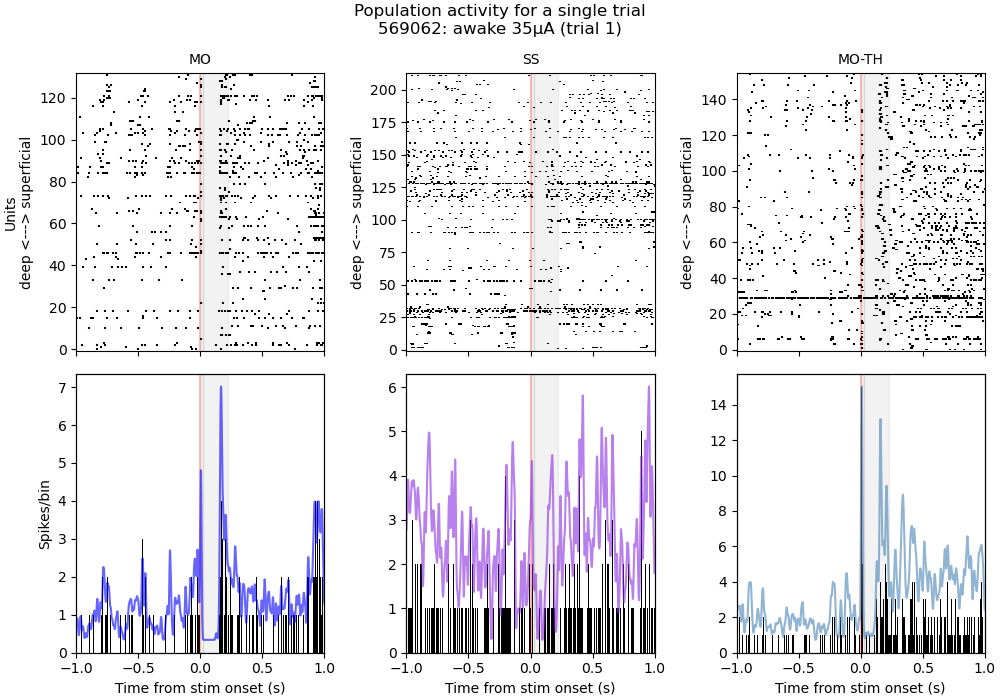

In [27]:
triali = 1

fig, axs = plt.subplots(2, len(ROI), figsize=(10,7), sharex=True, constrained_layout=True)

for coli, region in enumerate(ROI):
    select_units = df[df['parent'] == region].unit_id.values
    select_depths = df[df['parent'] == region].unit_depths.values
    depth_sort = np.squeeze(np.argsort(select_depths))[::-1] # in reverse order, because plots from bottom to top

    ## Spike raster ##
    axs[0,coli].axvline(0, color='r', alpha=0.25)
    axs[1,coli].axvline(0, color='r', alpha=0.25)
    for tt, win in peak_windows.items():
        axs[0,coli].axvspan(win[0], win[1], color='k', alpha=0.05)
        axs[1,coli].axvspan(win[0], win[1], color='k', alpha=0.05)

    pop_hist = []
    for indi, uniti in enumerate(select_units[depth_sort]):
        axs[0,coli].eventplot(
            [unit_trial_spikes[plexp][plstim][plstate][uniti][triali]], lineoffsets=indi, linelengths=0.95, color='black')
        pop_counts, edges = np.histogram(unit_trial_spikes[plexp][plstim][plstate][uniti][triali], bins)
        pop_hist.append(pop_counts)

    axs[0,coli].set_xlim(raster_window)
    axs[0,coli].set_ylim([-1, indi+1])
    axs[0,coli].set_title('{}'.format(region))
    # axs[0].set_yticklabels(
    # [select_depths[depth_sort][int(x)] if x >= 0 and x < len(select_depths) else x for x in axs[0].get_yticks()])

    ## Population PSTH ##
    pop_bin_counts = np.sum(np.array(pop_hist), axis=0)
    axs[1,coli].bar(bins[:-1] + time_bin/2, pop_bin_counts, width=time_bin*0.95, color='k')
    axs[1,coli].set_xlabel('Time from stim onset (s)')
    SDFax = axs[1,coli].twinx()
    SDFax.plot(
        bins[:-1] + time_bin/2, ndimage.gaussian_filter(pop_bin_counts, sigma=int(gausswin / time_bin), output=float),
        color=area_colors[region], linewidth=1.5, alpha=0.6
    )
    SDFax.set_yticks([])
    if coli == 0:
        axs[0,coli].set_ylabel('Units\ndeep <---> superficial')
        axs[1,coli].set_ylabel('Spikes/bin')
    else:
        axs[0,coli].set_ylabel('deep <---> superficial')
plt.suptitle(
    'Population activity for a single trial\n{}: {} {}\u03bcA (trial {:d})'.format(
        exp.mouse, plstate, plstim, triali), fontsize=12)
## Save ##
figname = 'allPOP_rasterSDF_{}_{}{}_trial{:d}.png'.format(exp.mouse, plstate, plstim, triali)
# fig.savefig(os.path.join(figsavedir, figname), transparent=True)

Test for single units

In [42]:
df[(
    (df['parent'] == 'MO') &
    (df['cell_type'] == plot_cell_type) &
    (df['response'] == plot_response_type)
)].unit_id.values

array(['F417', 'F415', 'F421', 'F426', 'F432', 'F431', 'F434', 'F449',
       'F451', 'F455', 'F466', 'F471', 'F477', 'F481', 'F486', 'F492',
       'F501', 'F502', 'F505', 'F508', 'F522', 'F524', 'F532', 'F525',
       'F527', 'F528', 'F533', 'F536', 'F551', 'F555', 'F554', 'F563',
       'F575', 'F579', 'F584', 'F597', 'F609'], dtype=object)

In [45]:
df[(
    (df['parent'] == 'MO') &
    (df['cell_type'] == plot_cell_type)
)].unit_id.values

array(['F417', 'F418', 'F415', 'F724', 'F411', 'F419', 'F421', 'F426',
       'F683', 'F432', 'F431', 'F434', 'F685', 'F437', 'F442', 'F445',
       'F446', 'F449', 'F450', 'F451', 'F455', 'F456', 'F457', 'F466',
       'F471', 'F691', 'F477', 'F485', 'F481', 'F486', 'F695', 'F727',
       'F493', 'F492', 'F499', 'F501', 'F502', 'F505', 'F507', 'F508',
       'F511', 'F696', 'F512', 'F698', 'F518', 'F522', 'F524', 'F532',
       'F525', 'F527', 'F528', 'F529', 'F700', 'F701', 'F533', 'F536',
       'F540', 'F545', 'F549', 'F551', 'F552', 'F728', 'F706', 'F704',
       'F555', 'F554', 'F556', 'F558', 'F553', 'F563', 'F566', 'F568',
       'F572', 'F570', 'F575', 'F709', 'F577', 'F578', 'F579', 'F581',
       'F583', 'F584', 'F710', 'F592', 'F596', 'F597', 'F602', 'F598',
       'F600', 'F609', 'F614', 'F737', 'F627', 'F630', 'F718'],
      dtype=object)

In [56]:
df[df['unit_id'] == 'F691']

,unit_id,area,parent,unit_depths,cell_type,response
784,F691,MOs6a,MO,940,RS,ns


In [28]:
time_bin = 0.0001 # size of time bins (s)
bins = np.arange(raster_window[0], raster_window[1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2
sigshort = 5 # Gaussian kernel length (Butovas&Schwarz2003 use short kernel for first excitatory response)
siglong = 50 # Gaussian kernel length (Butovas&Schwarz2003 use long kernel for rest of response)

<IPython.core.display.Javascript object>


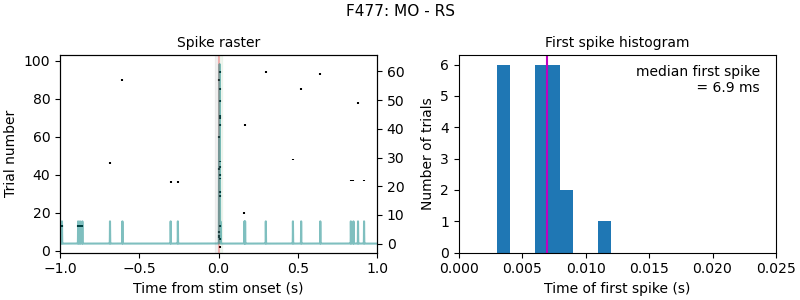

Text(0.5, 0.98, 'F477: MO - RS')

In [54]:
uniti = 'F477'

fig, axs = plt.subplots(1, 2, figsize=(8,3), constrained_layout=True)
## Spike raster ##
axs[0].axvline(0, color='r', alpha=0.25)
axs[0].axvspan(-spcount_window[1], -spcount_window[0], color='k', alpha=0.05)
axs[0].axvspan(spcount_window[0], spcount_window[1], color='g', alpha=0.05)

first_spikes = []
spike_rate = []
for indi, spikes in enumerate(unit_trial_spikes[plexp][plstim][plstate][uniti]):
    if not isinstance(spikes, np.ndarray):
        spikes = np.array([spikes])
    axs[0].eventplot([spikes], lineoffsets=indi, linelengths=0.95, color='black')
    
    early_spikes = np.nonzero((spikes > 0) & (spikes < spcount_window[1]))[0]
    if len(early_spikes) > 0:
        first_spikes.append(spikes[early_spikes[0]])
        
    sp_counts, edges = np.histogram(spikes, bins)
    spike_rate.append(sp_counts/time_bin)
    
axs[0].set_xlim(raster_window)
axs[0].set_ylim([-1, indi+1])
axs[0].set_xlabel('Time from stim onset (s)')
axs[0].set_ylabel('Trial number')
axs[0].set_title('Spike raster')

unitFR = np.mean(np.array(spike_rate), axis=0)
unitSDF = ndimage.gaussian_filter(unitFR, sigma=sigshort, output=float)
sdfax = axs[0].twinx()
sdfax.plot(timex, unitSDF, color='teal', alpha=0.5)

## First spike histogram ##
n, obins, patches = axs[1].hist(first_spikes, bins=np.arange(0, spcount_window[1]+0.001, 0.001))
axs[1].set_xlabel('Time of first spike (s)')
axs[1].set_ylabel('Number of trials')
axs[1].set_title('First spike histogram')
axs[1].set_xlim([obins[0], obins[-1]])
axs[1].axvline(np.median(first_spikes), color='m')
axs[1].text(
    0.95, 0.95, 'median first spike\n = {:.1f} ms'.format(np.median(first_spikes)*1E3),
    ha='right', va='top', transform=axs[1].transAxes, fontsize=10
)
plt.suptitle('{}: {} - {}'.format(uniti, 'MO', plot_cell_type), fontsize=11)

<IPython.core.display.Javascript object>


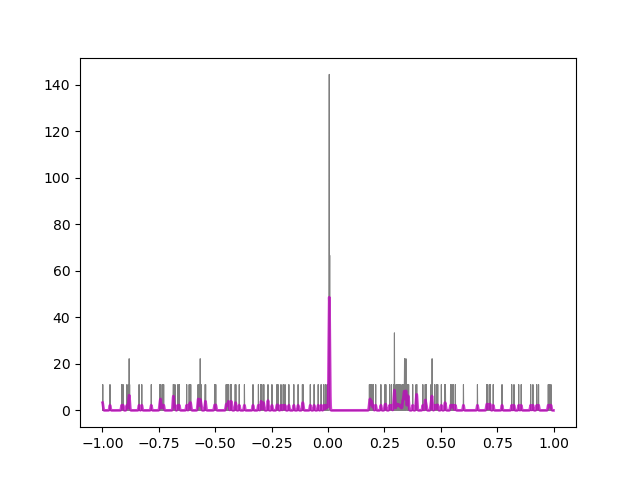

In [101]:
## Plot spike density function ##
## Params from AllenSDK ##
# num_timestep_second = 30
# sweep_length = 3.1
# filter_width = 0.1
time_bin = 0.001 # size of time bins (s)
bins = np.arange(raster_window[0], raster_window[1] + time_bin, time_bin)
winsize = 0.0025 # duration of convolution (s) 
fwidth = int(winsize / time_bin)

uniti = 'F326'
trial_rates = np.zeros((len(bins)-1, len(all_event_times[plexp][plstim][plstate])))
for triali, spikes in enumerate(unit_trial_spikes[plexp][plstim][plstate][uniti]):
    spike_train, edges = np.histogram(spikes, bins)
    trial_rates[:,triali] = spike_train / time_bin
    
sdf = ndimage.gaussian_filter(np.mean(trial_rates, axis=1), fwidth)

fig, ax = plt.subplots()
ax.plot(bins[:-1] + time_bin/2, np.mean(trial_rates, axis=1), color='k', linewidth=0.8, alpha=0.5)
ax.plot(bins[:-1] + time_bin/2, sdf, color='m', linewidth=2, alpha=0.75)

Looking at different elements of spike timing and probability. In general, as stim current increases: the number of trials with an initial spike increases, and the jitter of the first spike time decreases.

In [22]:
states_list = list(list(comp_states.values())[0].keys())
x = np.arange(len(currents_list))  # the label locations
width = 0.35  # the width of the bars
# barlocs = width * ((np.arange(len(currents_list)*len(states_list))-1) - len(currents_list)*len(states_list)/2)
barcolors = ['lightblue', 'dodgerblue', 'blue']
state_hatch = [None, 'xxx']

<IPython.core.display.Javascript object>


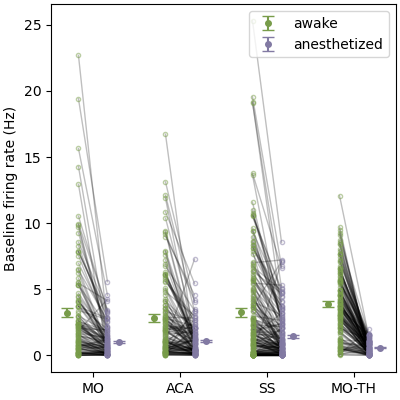

In [35]:
ROI = ['MO', 'ACA', 'SS', 'MO-TH']
plexp = 'MOs_1200'
plot_cell_type = 'RS'

delta = 0.4

fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
catx = np.arange(0, len(ROI)*(len(states_list)+1), len(states_list)+1)
for ii, region in enumerate(ROI):
    df = unit_responses[plexp][PCI_stim_amp]['awake']
    ROIunits = df[(df['parent'] == region) & (df['cell_type'] == plot_cell_type)].unit_id.values

    baseline_FR = np.zeros((len(states_list), len(ROIunits)), dtype=float)
    for unitind, uniti in enumerate(ROIunits):
        for coli, statei in enumerate(states_list):
            trial_blfr = []
            for parami in currents_list:
                for spikesi in unit_trial_spikes[plexp][parami][statei][uniti]:
                    trial_blfr.append(np.sum(spikesi < 0)) # this is spikes/s
            baseline_FR[coli, unitind] = np.mean(trial_blfr)

    x = catx[ii] + np.arange(baseline_FR.shape[0])
    ind_lines = ax.plot(x, baseline_FR, color='k', linewidth=1, alpha=0.25)
    aw_markers = ax.plot(
        np.zeros(len(ROIunits))+x[0], baseline_FR[0,:],
        color=state_colors['awake'], linestyle='none', marker='o', fillstyle='none', markersize=3, alpha=0.5
    )
    an_markers = ax.plot(
        np.zeros(len(ROIunits))+x[1], baseline_FR[1,:],
        color=state_colors['anesthetized'], linestyle='none', marker='o', fillstyle='none', markersize=3, alpha=0.5
    )
    # plot mean +/- SEM with filled circles
    mean_aw = ax.errorbar(
        x[0]-delta, np.mean(baseline_FR[0,:]), yerr=stats.sem(baseline_FR[0,:]),
        color=state_colors['awake'], linestyle='none', marker='o', markersize=4, capsize=4
    )
    mean_an = ax.errorbar(
        x[1]+delta, np.mean(baseline_FR[1,:]), yerr=stats.sem(baseline_FR[1,:]),
        color=state_colors['anesthetized'], linestyle='none', marker='o', markersize=4, capsize=4
    )

ax.set_ylabel('Baseline firing rate (Hz)')
ax.set_xticks(catx+0.5)
ax.set_xticklabels(ROI)
ax.legend([mean_aw, mean_an], states_list)

## Save ##
figname = 'baseline_FRs_{}.png'.format(exp.mouse)
# fig.savefig(os.path.join(figsavedir, figname), transparent=True)

Make raster, plus for all units in regions of interest.

In [75]:
rasterdir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + exp.mouse, 'rasters_timing')
if not os.path.exists(rasterdir):
    os.mkdir(rasterdir)

### Make a raster plots for all units for all trial types.